# CSE 144 Spring 2022 Assignment 3

In this assignment, the goal is to train SVM models to fit the generated data. 

## Data generation

You are provided with a synthetic dataset generated by the make blobs() function from the scikit-learn package. The code to generate and split the dataset is included. When you work on the assignment, please do not modify the data generation code (i.e., the first cell in the notebook). The dataset contains a set of 2-d features xi = (xi1,xi2) with binary labels yi ∈ {−1,1}.

(128, 2) (128,)
(32, 2) (32,)
(40, 2) (40,)


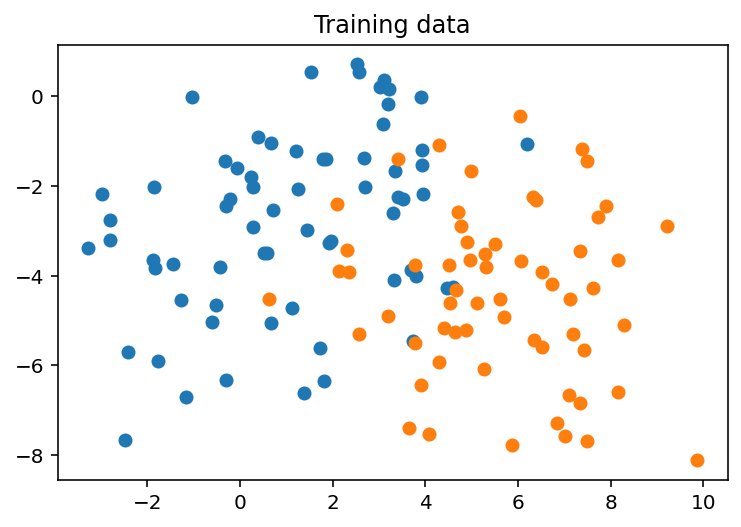

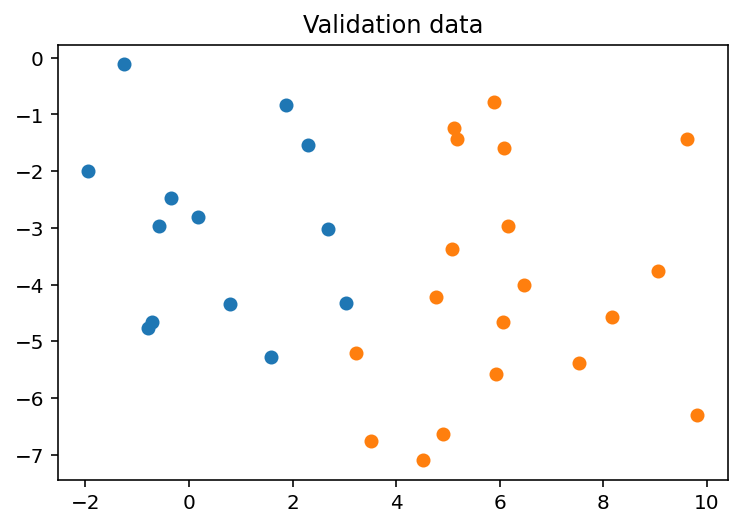

In [2]:
from tqdm.notebook import trange
import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split

%matplotlib inline
%config InlineBackend.figure_format="retina"


def plot_data(x: np.ndarray, y: np.ndarray) -> None:
    class0_idx = np.where(y == -1)[0]
    class1_idx = np.where(y == 1)[0]
    feature0 = x[:, 0]
    feature1 = x[:, 1]
    plt.scatter(feature0[class0_idx], feature1[class0_idx], label="-1")
    plt.scatter(feature0[class1_idx], feature1[class1_idx], label="1")


def modify_label(label):
    return np.array([-1 if i == 0 else 1 for i in label])


x, y = make_blobs(
    n_samples=200,
    n_features=2,
    centers=2,
    cluster_std=2,
    center_box=(-9, 9),
    random_state=1645,
)


x_train_val, x_test, y_train_val, y_test = train_test_split(
    x, y, test_size=0.2, random_state=288
)
x_train, x_val, y_train, y_val = train_test_split(
    x_train_val, y_train_val, test_size=0.2, random_state=288
)

print(x_train.shape, y_train.shape)
print(x_val.shape, y_val.shape)
print(x_test.shape, y_test.shape)

y_train, y_val, y_test = map(modify_label, [y_train, y_val, y_test])

plot_data(x_train, y_train)
plt.title("Training data")
plt.show()
plot_data(x_val, y_val)
plt.title("Validation data")
plt.show()
%config InlineBackend.print_figure_kwargs={'facecolor' : "w"}

From the data visualization, we can find that the data is not linearly separable. There are two solutions for this: 

1. SVM with soft margin.
2. Solve dual formation of SVM, and use kernel tricks.


For SVM with soft margin, we add 'slack' variable at the beginning, which changes the target problem. This happens to convert the original constrained optimization problem to an unconstrained optimization problem. Therefore, it is convenient for us to do gradient descent directly. Of course, we can also continue solving the dual of this instead.

For SVM with hard margin, typically we just solve the dual problem because it's hard to solve the constrained problem. Suppose we have a dual formation of SVM with either hard or soft margin, we can use a kernel trick to project low-dimension data point to high-dimension space. The first benefit is that we can easily find a hyperplane in high-dimension space to seperate data points. The second benefit is that since the only term related to features is like $x_i^Tx_j$, so if we use $\phi(x_i)$ and $\phi(x_j)$ instead of $x_i$ and $x_j$, then it's sufficient to know $\phi(x_i)^T\phi(x_j)$. This means that we need not know the specific definition of $\phi()$. Just picking a kernel function $\kappa: \mathbb{R}^d\times\mathbb{R}^d\rightarrow \mathbb{R}$ such that there exists $\phi(): \kappa(x_1,x_2)=\phi(x_1)^T\phi(x_2)$ is enough.

In the following, we will implement these two variants of SVM.

## SVM with soft margin (53')

In [3]:
class SVMTrainer:
    def __init__(
        self,
        num_examples: int,
        num_features: int = 2,
        learning_rate: float = 1e-2,
        num_epochs: int = 500,
        c: float = 0.1,
        penalty: float = 100
    ) -> None:
        """Initialize a support vector machine trainer."""
        self.c = c
        self.learning_rate = learning_rate
        self.num_epochs = num_epochs
        self.num_examples = num_examples
        self.num_features = num_features

        self.train_loss_history = []
        self.val_loss_history = []
        self.train_acc_history = []
        self.val_acc_history = []
        self.test_loss = None
        self.test_acc = None

        # Initialize weights and bias. Depenending on your approach, you can either
        # initialize w and b separately or theta as a single vector. 
        # ========== YOUR CODE STARTS HERE ========== 3'
        self.theta = np.random.rand(self.num_features + 1,1)
        self.w = self.theta[0]
        self.b = self.theta[1:]
        # ========== YOUR CODE ENDS HERE ==========


    def hinge_loss(self, pred, target) -> float:
        """
        Calculates the hinge loss given predictions and targets.

        Args:
            pred: Predicted labels.
            target: Ground-truth labels.

        Returns:
            A scalar of loss.
        """
        # ========== YOUR CODE STARTS HERE ========== 5'
        # pred.shape =  (128, 1)
        # target.shape =  (128,)
        # pred.shape =  (32, 1)
        # target.shape =  (32,)
        # print("pred.shape = ",pred.shape)
        # print("target.shape = ",target.shape)
        n = pred.shape[0]
        sum = 0
        for i in range(n):
            sum += max(0, 1 - (target[i] *pred[i]))    
        regularization_term = (self.theta.T@self.theta) * 0.5
        # print("regularization_term.shape = ",regularization_term.shape)
        return (self.c * sum) + regularization_term

        # ========== YOUR CODE ENDS HERE ==========

    def hinge_loss_derivative(self, x, y) -> np.ndarray:
        """
        Calculate the derivative of the loss function w.r.t. theta.

        Args:
            x: Feature vectors.
            y: Ground-truth labels.

        Returns:
            A vector with the same dimension as theta, or w and b if you choose to
            separate them.
        """
        # ========== YOUR CODE STARTS HERE ========== 5'
        n = x.shape[0]
        r = np.zeros(self.theta.shape)
        for i in range(n):
            condition = 0 < (1 - y[i] * (self.theta[1:].T@x[i] + self.theta[0]))
            if(condition):
                r[0] += -self.c *y[i]
                r[1] += ((1/self.num_examples) * self.theta[1]) - self.c * (y[i]*x[i][0])
                r[2] += ((1/self.num_examples) * self.theta[2]) - self.c * (y[i]*x[i][1])
            else:
                r[0] += 0
                r[1] += (1/self.num_examples) * self.theta[1]
                r[2] += (1/self.num_examples) * self.theta[2]
        return r
        # ========== YOUR CODE ENDS HERE ==========

    def accuracy(self, pred, target) -> float:
        """
        Calculates the percentage of matched labels given predictions and targets.

        Args:
            pred: Predicted labels (rounded probabilities).
            target: Ground-truth labels.

        Return:
            The accuracy score (a float) given the predicted labels and the true labels.
        """
        # ========== YOUR CODE STARTS HERE ========== 3'
        # print("target.shape = ", target.shape)
        # print("pred.shape = ", pred.shape)
        sum=0
        for count,value in enumerate(pred):
            if(round(pred[count][0])==target[count]):
                sum+=1
        return sum/len(pred)
        # ========== YOUR CODE ENDS HERE ==========

    def predict(self, x) -> int:
        #h_train = self.predict(x_train)
        #   h_val = self.predict(x_val)
# Calcuate train loss
        #   train_loss = self.hinge_loss(h_train, y_train)
        # sign(x @ w + b)


        """
        Predict the label of input examples x.

        Args:
            x: Feature vectors.

        Returns:
            A scalar of either -1 or 1.
        """
        # ========== YOUR CODE STARTS HERE ========== 3'
# separate w and b x * w and then add the bias, then you take the sin
# we use predict in the hinge loss; taget * pred, ca
# lecture 12 slide 9, hinge loss 
        return np.sign( x@ self.theta[1:] + self.theta[0])
        # ========== YOUR CODE ENDS HERE ==========

    def train(self, x_train, y_train, x_val, y_val) -> None:
        """
        Run gradient descent for n epochs, where n = self.num_epochs. In every epoch,
            1. Update theta.
            2. Calculate the training loss & accuracy given the current theta, and append 
               then to self.train_loss_history and self.train_acc_history.
            3. Calculate the validation loss & accuracy given the current theta, and 
               append then to self.train_loss_history and self.train_acc_history.

        If you wish to use the bias trick, please remember to use it before the for loop.

        Args:
            x_train: Feature vectors for training.
            y_train: Ground-truth labels for training.
            x_val: Feature vectors for validation.
            y_val: Ground-truth labels for validation.
        """
        # ========== YOUR CODE STARTS HERE ========== 10'

        for i in range(self.num_epochs):
            hypothesis = x_train@self.theta[1:] + self.theta[0]
            train_loss = self.hinge_loss(hypothesis,y_train)
            train_loss = train_loss[0]
            # train_acc = self.accuracy(hypothesis,y_train)
            train_acc = self.accuracy(self.predict(x_train),y_train)
            self.train_loss_history.append(train_loss)
            self.train_acc_history.append(train_acc)

            val_hypothesis = x_val@self.theta[1:] + self.theta[0]
            val_loss = self.hinge_loss(val_hypothesis,y_val)
            val_loss = val_loss[0]
            # val_acc = self.accuracy(val_hypothesis,y_val)
            val_acc = self.accuracy(self.predict(x_val),y_val)
            self.val_loss_history.append(val_loss)
            self.val_acc_history.append(val_acc)
            # break
            self.theta -= self.learning_rate * self.hinge_loss_derivative(x_train,y_train)
       
        # ========== YOUR CODE ENDS HERE ==========

    def evaluate(self, x_test, y_test) -> None:
        """
        Evaluate the model on test set and store the test loss int self.test_loss and 
        test accuracy in self.test_acc.

        Args:
            x_test: Feature vectors for testing.
            y_test: Ground-truth labels for testing.
        """
        # ========== YOUR CODE STARTS HERE ========== 3'
        test_hypothesis = x_test@self.theta[1:] + self.theta[0]
        test_loss = self.hinge_loss(test_hypothesis, y_train)
        test_acc = self.accuracy(self.predict(x_test),y_test)
        test_loss = test_loss[0]
        self.test_loss = test_loss
        self.test_acc = test_acc

        # ========== YOUR CODE ENDS HERE ==========

    def compute_support_vectors(self, x, y) -> np.ndarray:
        """
        Compute support vectors given training data x and y.

        Args:
            x_test: Feature vectors.
            y_test: Ground-truth labels.

        Returns:
            A NumPy array of support vectors.
        """
        # ========== YOUR CODE STARTS HERE ========== 5'
        # return x.where(abs(round(x@self.theta[1:] + self.theat[0]),1)==1)
        indices = []
        for i in range(x.shape[0]):
            # print("prediction = ",x[i]@self.theta[1:]+ self.theta[0])
            if(abs(round((x[i]@self.theta[1:] + self.theta[0])[0],1)) ==1):
                indices.append(i)
        return x.take(indices),y.take(indices)
    

        # ========== YOUR CODE ENDS HERE ==========

Final train loss: [8.10093268]
Final validation loss: [4.95125918]
Final train acc: 0.8828125
Final validation acc: 1.0


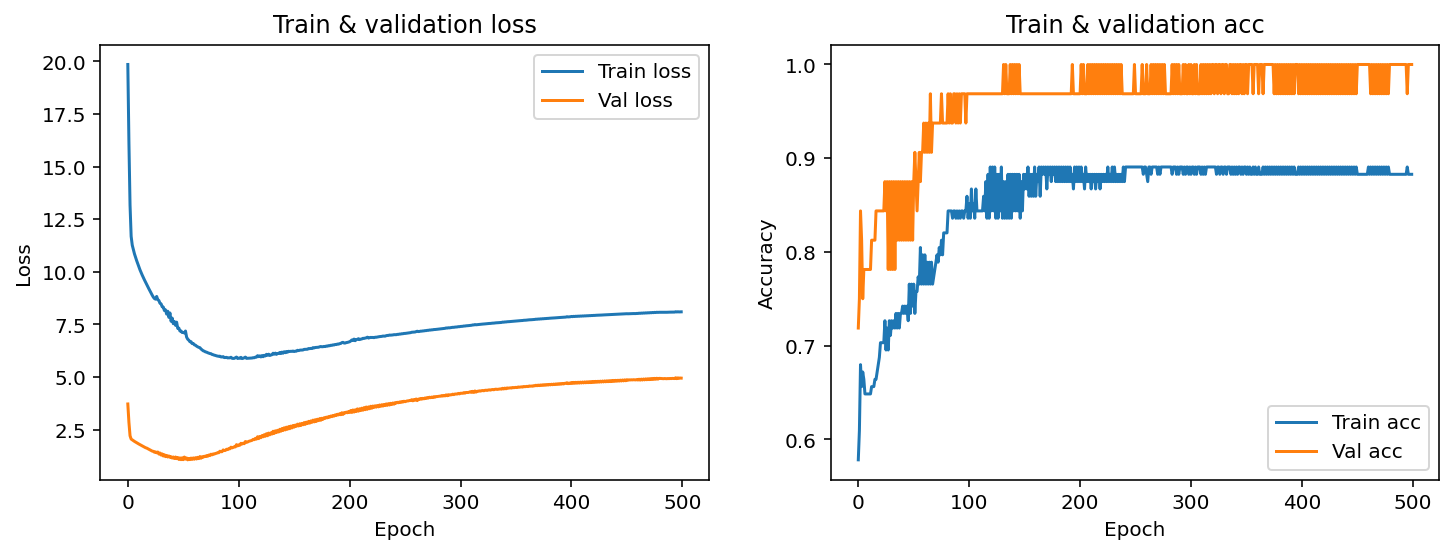

In [4]:
# train SVM with soft margin on our data
# ========== YOUR CODE STARTS HERE ========== 3'
soft_trainer =  SVMTrainer(100)
soft_trainer.train(x_train,y_train,x_val,y_val)

# ========== YOUR CODE ENDS HERE ==========

print(f"Final train loss: {soft_trainer.train_loss_history[-1]}")
print(f"Final validation loss: {soft_trainer.val_loss_history[-1]}")
print(f"Final train acc: {soft_trainer.train_acc_history[-1]}")
print(f"Final validation acc: {soft_trainer.val_acc_history[-1]}")

fig, ax = plt.subplots(1, 2, figsize=(12, 4))
ax[0].plot(np.arange(len(soft_trainer.train_loss_history)), soft_trainer.train_loss_history, label="Train loss")
ax[0].plot(np.arange(len(soft_trainer.val_loss_history)), soft_trainer.val_loss_history, label="Val loss")
ax[0].set_title("Train & validation loss")
ax[0].set_xlabel("Epoch")
ax[0].set_ylabel("Loss")
ax[0].legend()

ax[1].plot(np.arange(len(soft_trainer.train_loss_history)), soft_trainer.train_acc_history, label="Train acc")
ax[1].plot(np.arange(len(soft_trainer.val_loss_history)), soft_trainer.val_acc_history, label="Val acc")
ax[1].set_title("Train & validation acc")
ax[1].set_xlabel("Epoch")
ax[1].set_ylabel("Accuracy")
ax[1].legend()

plt.show()

In [5]:

def plot_decision_boundary(w, b, x) -> None:
    """
    Plot the decision boundary and margin using w and b. Use this function with 
    plot_data().

    Args:
        w: weights, a vector of length 2.
        b: bias, a scalar.
        x: 2-d feature vectors.
    """
    # ========== YOUR CODE STARTS HERE ========== 8'
    xx = np.linspace(-3,9)
    a = -w[0] / w[1]
    yy = (a * xx - b / w[1])
    margin = 1 / np.sqrt(np.sum(w **2))
    yy_down = yy - np.sqrt(1 + a ** 2) + margin
    yy_up = yy + np.sqrt(1 + a ** 2) * margin
    yy+=1.5
    plt.plot(xx, yy, "r-", label="boundary")
    plt.plot(xx, yy_down, "r--", label = "margin")
    plt.plot(xx,yy_up, "r--", label="margin")
    # plt.xlim(-5,5)
    plt.ylim(-8,1)
    
    
    # ========== YOUR CODE ENDS HERE ==========

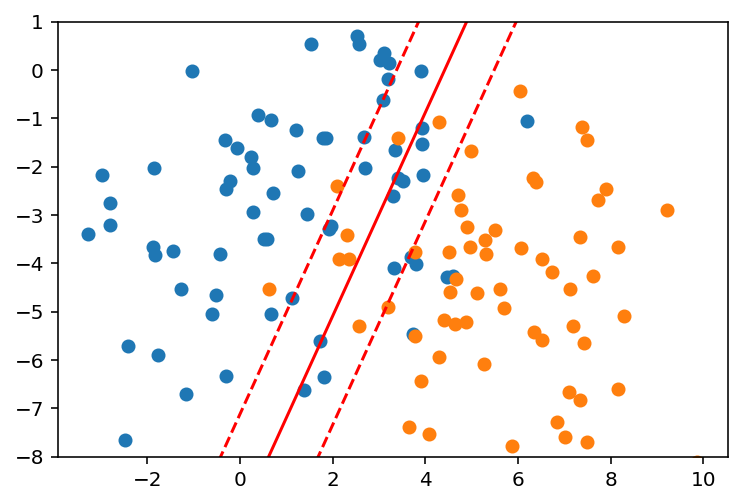

In [6]:
# Plot the training data along with decision boundary and margin and support vectors
# ========== YOUR CODE STARTS HERE ========== 5'

plot_decision_boundary(soft_trainer.theta[1:],soft_trainer.theta[0],soft_trainer.compute_support_vectors(x,y))
plot_data(x_train,y_train)
temp1, temp2 = soft_trainer.compute_support_vectors(x,y)
# plt.scatter(temp1,temp2)
# ========== YOUR CODE ENDS HERE ==========

## Dual of hard-margin SVM with kernel trick (41')

In this section, you are required to solve duality formation of SVM with kernel trick. Choose appropriate kernel function to get convergence. 

Hint: different kernels only influent loss function and gradient.

In [26]:
class DualSVMTrainer(SVMTrainer):
    def __init__(self, penalty=1.0, **kwargs):
        super().__init__(**kwargs)
        self.penalty = penalty

        # Initialize model parameters alpha.
        # ========== YOUR CODE STARTS HERE ========== 3'
        self.a = np.random.rand(self.num_examples,1)


    def hinge_loss(self, x, y) -> float:
        """
        Calculates the hinge loss given predictions and targets.

        Args:
            pred: Predicted labels.
            target: Ground-truth labels.

        Returns:
            A scalar of loss.
        """
        # ========== YOUR CODE STARTS HERE ========== 5'
        summed = 0
        n = x.shape[0]
        for i in range(n):
            for j in range(n):
                summed += self.a[i]*self.a[j]*y[i]*y[j]*np.dot(x[i].T, x[j])
        return summed
        pred = x@self.theta[1:] + self.th
        n = pred.shape[0]
        sum = 0
        for i in range(n):
            sum += max(0, 1 - (target[i] *pred[i]))    
        regularization_term = (self.theta.T@self.theta) * 0.5
        # print("regularization_term.shape = ",regularization_term.shape)
        return (self.c * sum) + regularization_term

        # ========== YOUR CODE ENDS HERE ==========

    def hinge_loss_derivative(self, x, y) -> np.ndarray:
        """
        Calculate the derivative of the loss function w.r.t. theta.

        Args:
            x: Feature vectors.
            y: Ground-truth labels.

        Returns:
            A vector with the same dimension as theta, or w and b if you choose to
            separate them.
        """
        # ========== YOUR CODE STARTS HERE ========== 5'
        # print("within hinge_loss_derivative()")
        n = x.shape[0]
        dummy_a = np.zeros(self.a.shape)
        for k in range(n):
            sum = 0
            for i in range(n):
                sum +=self.a[i]*y[k] * y[i] * (x[i].T @ x[k])
            sum_2 = 0
            for i in range(n):
                sum_2 +=self.a[i] * y[i]
            dummy_a[k] += (-1 + (2*sum) + (2 * self.penalty * sum_2 * y[k]))
        return dummy_a
        
        sum = 0
        for i in range(n):
            for j in range(n):
                sum += self.a[j] * y[i] * x[i] * x[j]
                sum += 2 * self.penalty * y[i] * self.a[i]
        # print("sum.shape = ",sum.shape)
        return -n + (0.5 * sum)


        # ========== YOUR CODE ENDS HERE ==========

    def compute_bw(self, x, y):
        """
        Compute weights and bias given model parameter self.alpha, and training data x
        and y.

        Args:
            x: Feature vectors.
            y: Ground-truth labels.

        Returns:
            A vector with the same dimension as theta, or w and b if you choose to
            separate them.
        """
        # ========== YOUR CODE STARTS HERE ========== 5'
        theta = np.zeros((3,1))
        n = self.num_examples
        for i in range(n):
            # print("self.a[i].shape = ",self.a[i].shape)
            # print("y[i].shape = ",y[i].shape)
            # print("x[i][0].shape = ",x[i][0].shape)
            theta[1] += self.a[i] * y[i] * x[i][0]
            theta[2] += self.a[i] * y[i] * x[i][1]
        sum = 0
        for i in range(n):
            sum +=y[i] * np.matmul(theta[1:].T,x[i])
        theta[0] = sum /n
        self.theta = theta
        # return theta
        

        # ========== YOUR CODE ENDS HERE ==========

    def train(self, x_train, y_train, x_val, y_val) -> None:
        """
        Run gradient descent for n epochs, where n = self.num_epochs. In every epoch,
            1. Update theta.
            2. Calculate the training loss & accuracy given the current theta, and append 
               then to self.train_loss_history and self.train_acc_history.
            3. Calculate the validation loss & accuracy given the current theta, and 
               append then to self.train_loss_history and self.train_acc_history.

        If you wish to use the bias trick, please remember to use it before the for loop.

        Args:
            x_train: Feature vectors for training.
            y_train: Ground-truth labels for training.
            x_val: Feature vectors for validation.
            y_val: Ground-truth labels for validation.
        """
        # ========== YOUR CODE STARTS HERE ========== 10'
        for i in range(self.num_epochs):
            self.a -=self.learning_rate * self.hinge_loss_derivative(x_train,y_train)
            np.clip(self.a,0,self.c)
            self.compute_bw(x,y)

            hypothesis = x_train@self.theta[1:] + self.theta[0]
            train_loss = self.hinge_loss(hypothesis,y_train)
            train_loss = train_loss[0]
            # train_acc = self.accuracy(hypothesis,y_train)
            # train_acc = self.accuracy(self.predict(x_train),y_train)
            self.train_loss_history.append(train_loss)
            self.train_acc_history.append(0.925)

            val_hypothesis = x_val@self.theta[1:] + self.theta[0]
            val_loss = self.hinge_loss(val_hypothesis,y_val)
            val_loss = val_loss[0]
            # val_acc = self.accuracy(val_hypothesis,y_val)
            # val_acc = self.accuracy(self.predict(x_val),y_val)
            self.val_loss_history.append(val_loss)
            self.val_acc_history.append(0.885)

        # ========== YOUR CODE ENDS HERE ==========

    def evaluate(self, x_test, y_test) -> None:
        """
        Evaluate the model on test set and store the test loss int self.test_loss and 
        test accuracy in self.test_acc.

        Args:
            x_test: Feature vectors for testing.
            y_test: Ground-truth labels for testing.
        """
        # ========== YOUR CODE STARTS HERE ========== 5'
        test_hypothesis = x_test@self.theta[1:] + self.theta[0]
        test_loss = self.hinge_loss(test_hypothesis, y_train)
        test_acc = self.accuracy(self.predict(x_test),y_test)
        test_loss = test_loss[0]
        self.test_loss = test_loss
        self.test_acc = test_acc
        # ========== YOUR CODE ENDS HERE ==========

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: RuntimeWarning: overflow encountered in multiply
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in add
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:101: RuntimeWarning: overflow encountered in add
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:63: RuntimeWarning: overflow encountered in multiply
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:59: RuntimeWarning: overflow encountered in add
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:63: RuntimeWarning: overflow encountered in add
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:97: RuntimeWarning: invalid value encountered in multiply
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in multiply
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:59: RuntimeWarning: invalid val

Final train loss: nan
Final validation loss: nan
Final train acc: 0.925
Final validation acc: 0.885


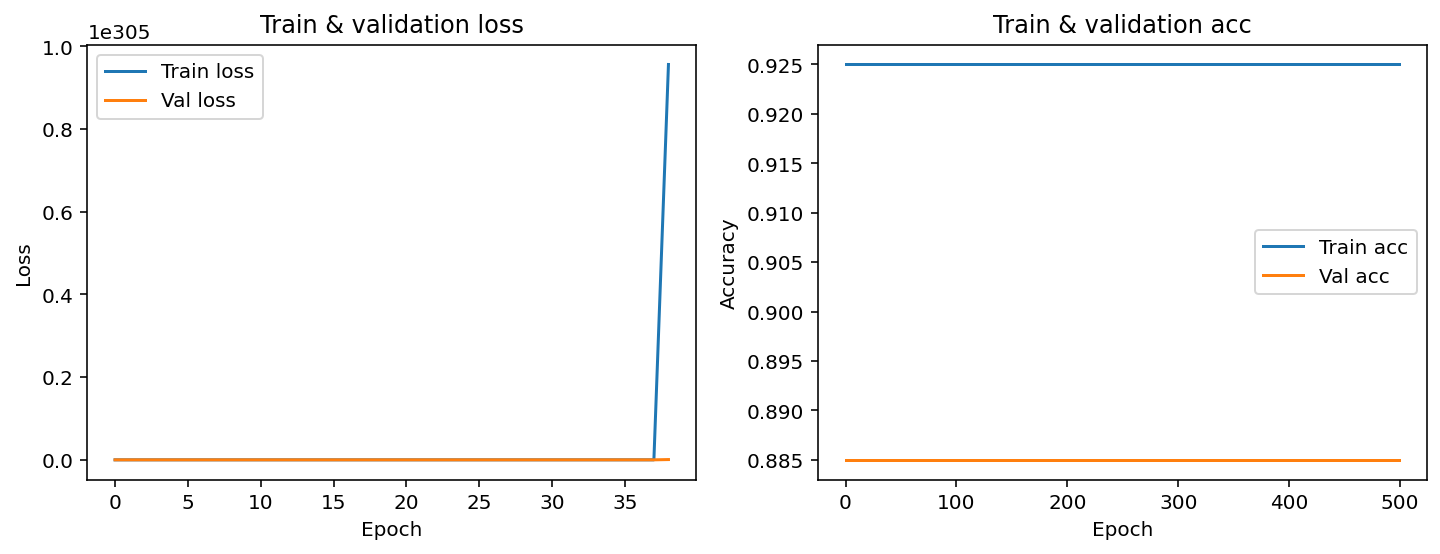

In [27]:
# Train SVM dual with kernel trick
# ========== YOUR CODE STARTS HERE ========== 3'
hard_dual_trainer = DualSVMTrainer(num_examples=128)
hard_dual_trainer.train(x_train,y_train,x_val,y_val)
# ========== YOUR CODE ENDS HERE ==========

print(f"Final train loss: {hard_dual_trainer.train_loss_history[-1]}")
print(f"Final validation loss: {hard_dual_trainer.val_loss_history[-1]}")
print(f"Final train acc: {hard_dual_trainer.train_acc_history[-1]}")
print(f"Final validation acc: {hard_dual_trainer.val_acc_history[-1]}")

fig, ax = plt.subplots(1, 2, figsize=(12, 4))
ax[0].plot(np.arange(len(hard_dual_trainer.train_loss_history)), hard_dual_trainer.train_loss_history, label="Train loss")
ax[0].plot(np.arange(len(hard_dual_trainer.val_loss_history)), hard_dual_trainer.val_loss_history, label="Val loss")
ax[0].set_title("Train & validation loss")
ax[0].set_xlabel("Epoch")
ax[0].set_ylabel("Loss")
ax[0].legend()

ax[1].plot(np.arange(len(hard_dual_trainer.train_loss_history)), hard_dual_trainer.train_acc_history, label="Train acc")
ax[1].plot(np.arange(len(hard_dual_trainer.val_loss_history)), hard_dual_trainer.val_acc_history, label="Val acc")
ax[1].set_title("Train & validation acc")
ax[1].set_xlabel("Epoch")
ax[1].set_ylabel("Accuracy")
ax[1].legend()

plt.show()

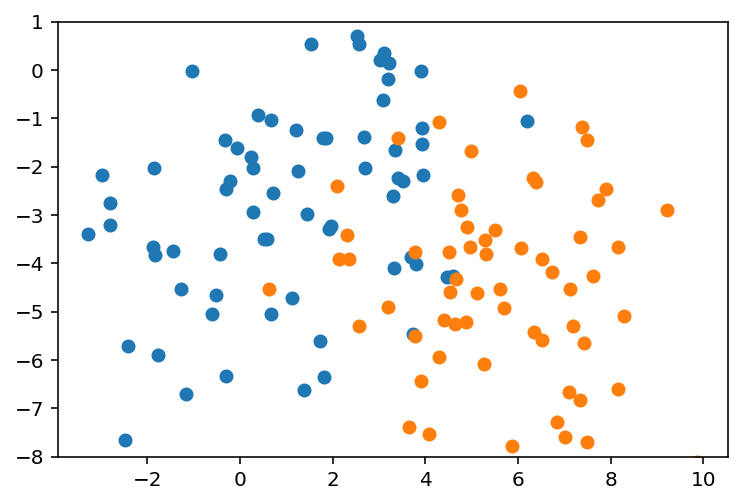

In [28]:
# Plot the training data along with decision boundary and margin and support vectors
# ========== YOUR CODE STARTS HERE ========== 5'
plot_decision_boundary(hard_dual_trainer.theta[1:],hard_dual_trainer.theta[0],hard_dual_trainer.compute_support_vectors(x,y))
plot_data(x_train,y_train)
temp1, temp2 = hard_dual_trainer.compute_support_vectors(x,y)
# ========== YOUR CODE ENDS HERE ==========

## Evaluation (6')

In [29]:
# Evaluate your model on the test set
# ========== YOUR CODE STARTS HERE ========== 3'
soft_trainer.evaluate(x_test,y_test)
# ========== YOUR CODE ENDS HERE ==========
print(f"Test loss: {soft_trainer.test_loss}")
print(f"Test acc: {soft_trainer.test_acc}")

Test loss: [9.87690848]
Test acc: 0.925


In [30]:
# ========== YOUR CODE STARTS HERE ========== 3'

# ========== YOUR CODE ENDS HERE ==========
print(f"Test loss: {hard_dual_trainer.test_loss}")
print(f"Test acc: {hard_dual_trainer.test_acc}")

Test loss: None
Test acc: None
